# Predicting Price with Location

In [1]:
pwd

'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model'

## Library importing

In [2]:
#importing libraries
import numpy as np #mathematical operations
import pandas as pd
import plotly.express as px #for visualisation
import plotly.graph_objects as go #for visualisation
from sklearn.impute import SimpleImputer #for inputting missing values
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline, make_pipeline #take diff components of model and put it together 
from sklearn.utils.validation import check_is_fitted

## Data Wrangling

In [3]:
#Loading the dataset with a function
def wrangle (filepath):
    #Load the CSV file into file path-local function applied
    df = pd.read_csv(filepath, encoding='ISO-8859-1')
    #To display 'Capital Federal' only 
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    #To display 'Apartment' only 
    mask_apt = df["property_type"] == "apartment" 
    #To display price below'400,000'
    mask_price = df["price_aprox_usd"] < 400_000
    #Subset
    df = df[ mask_ba & mask_apt & mask_price]
    
    #Remove outliers by 'surface_area_m2' -----removing the 10th and 90th quantiles
    low = df["surface_covered_in_m2"].quantile(0.1)
    high = df["surface_covered_in_m2"].quantile(0.9)
    
    mask_area = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_area]
    
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    print('low = ', low, ';high = ', high)
    print('df.shape = ', df.shape)
    
    return df

In [4]:
#wrangle to the function
frame1 = wrangle("C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model/buenos-aires-real-estate-1.csv")
frame1.info()
#Copy of the dataset
frame1cpy = frame1.copy()

low =  31.0 ;high =  100.0
df.shape =  (1343, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1343 entries, 4 to 8604
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1343 non-null   int64  
 1   operation                   1343 non-null   object 
 2   property_type               1343 non-null   object 
 3   place_with_parent_names     1343 non-null   object 
 4   price                       1343 non-null   float64
 5   currency                    1343 non-null   object 
 6   price_aprox_local_currency  1343 non-null   float64
 7   price_aprox_usd             1343 non-null   float64
 8   surface_total_in_m2         965 non-null    float64
 9   surface_covered_in_m2       1343 non-null   float64
 10  price_usd_per_m2            927 non-null    float64
 11  price_per_m2                1343 non-null   float64
 12  floor                       379 non-null

In [5]:
frame2 = wrangle("C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model/buenos-aires-real-estate-2.csv")
frame2.info()
#Copy of the dataset
frame2cpy = frame2.copy()

low =  31.0 ;high =  100.0
df.shape =  (1315, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1315 entries, 2 to 8585
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  1315 non-null   int64  
 1   operation                   1315 non-null   object 
 2   property_type               1315 non-null   object 
 3   place_with_parent_names     1315 non-null   object 
 4   price                       1315 non-null   float64
 5   currency                    1315 non-null   object 
 6   price_aprox_local_currency  1315 non-null   float64
 7   price_aprox_usd             1315 non-null   float64
 8   surface_total_in_m2         933 non-null    float64
 9   surface_covered_in_m2       1315 non-null   float64
 10  price_usd_per_m2            891 non-null    float64
 11  price_per_m2                1315 non-null   float64
 12  floor                       390 non-null

In [6]:
#Concatenate the dataframe 
df = pd.concat([frame1, frame2], ignore_index=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2658 non-null   int64  
 1   operation                   2658 non-null   object 
 2   property_type               2658 non-null   object 
 3   place_with_parent_names     2658 non-null   object 
 4   price                       2658 non-null   float64
 5   currency                    2658 non-null   object 
 6   price_aprox_local_currency  2658 non-null   float64
 7   price_aprox_usd             2658 non-null   float64
 8   surface_total_in_m2         1898 non-null   float64
 9   surface_covered_in_m2       2658 non-null   float64
 10  price_usd_per_m2            1818 non-null   float64
 11  price_per_m2                2658 non-null   float64
 12  floor                       769 non-null    float64
 13  rooms                       2137 

,Unnamed: 0,operation,property_type,place_with_parent_names,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon
0,5,sell,apartment,|Argentina|Capital Federal|Chacarita|,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693
1,10,sell,apartment,|Argentina|Capital Federal|Villa Luro|,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115
2,30,sell,apartment,|Argentina|Capital Federal|Caballito|,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957
3,41,sell,apartment,|Argentina|Capital Federal|Constitución|,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382
4,42,sell,apartment,|Argentina|Capital Federal|Once|,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511


## Visualisation

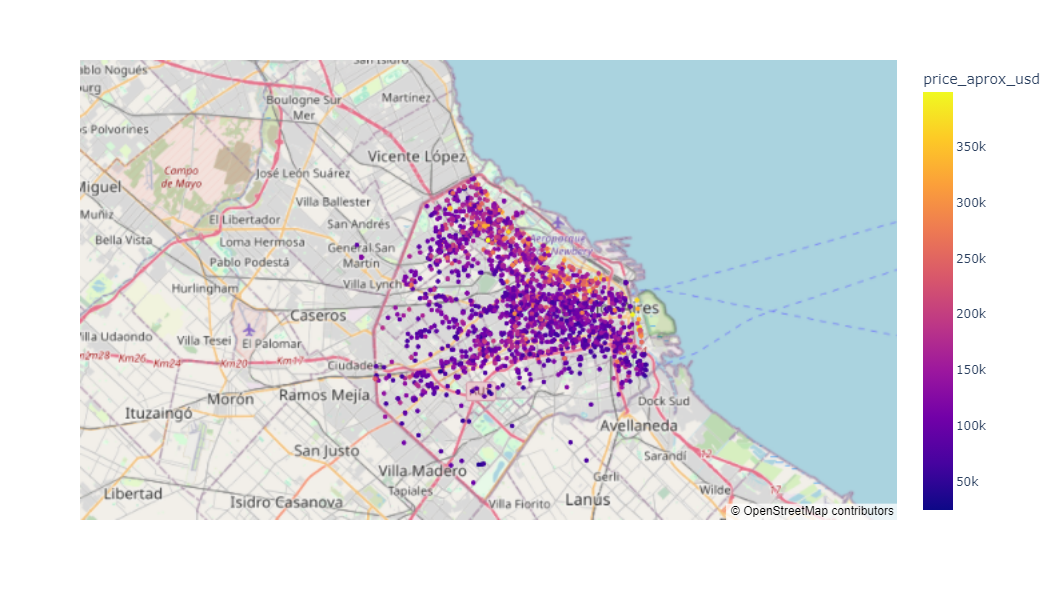

In [33]:
#Creating a scatter mapbox plot to visualise the data
fig1 = px.scatter_mapbox(
        df,
        lat="lat",
        lon="lon",
        width=600,
        height=600,
        color="price_aprox_usd",
        hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig1.update_layout(mapbox_style="open-street-map")

fig1.show()

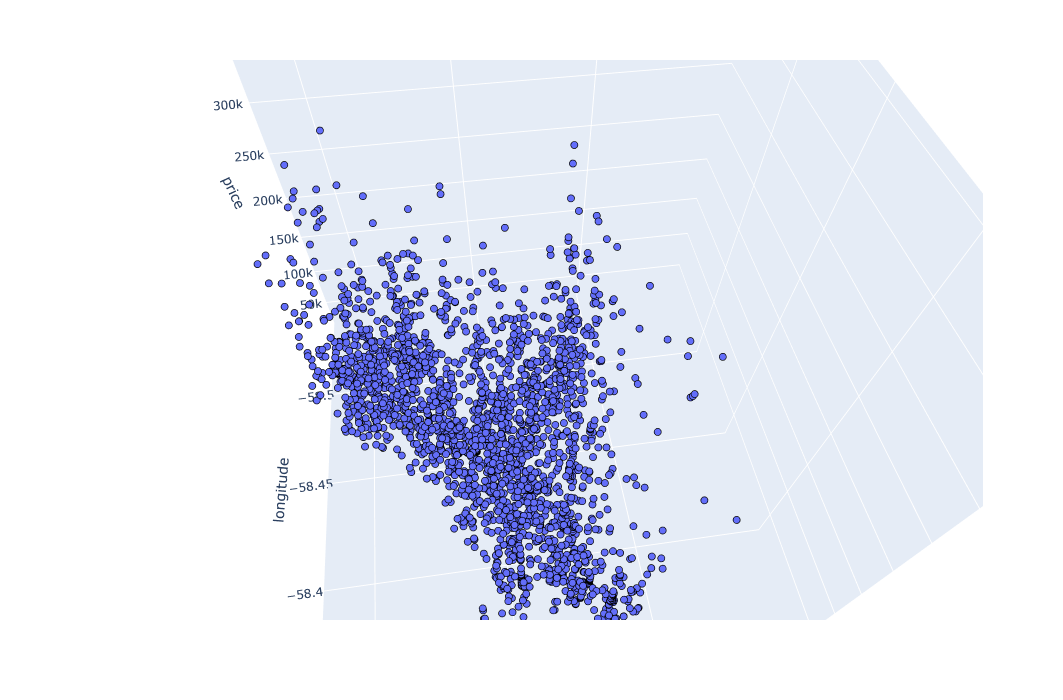

In [41]:
#Creating a 3D visualisation of the data
fig2 = px.scatter_3d(
        df,
        x= "lat",
        y= "lon",
        z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=700,
    height=700,
)

# Refine formatting
fig2.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig2.show()

## Model Building & Testing

In [42]:
#split the data into features and a target
features = ["lat", "lon"]
X_train = df[features]

#traget
target = ["price_aprox_usd"]
y_train = df[target]

#Mean of the target
y_mean = y_train.mean()
y_mean.head()

#Create a baseline list of the mean of the target
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:10]

#Calculate the mean absolute error
MAE = mean_absolute_error(y_train, y_pred_baseline)
print("Baseline Error:" , MAE)
print("Mean apt price", round(y_mean, 2))


Baseline Error: 45422.75166805662
Mean apt price price_aprox_usd    134732.97
dtype: float64


### Iterate

In [10]:
#creating an imputter for the missing values
imputer = SimpleImputer()

In [11]:
#Fit the model
imputer.fit(X_train)

SimpleImputer()

In [13]:
#Transform the data
XT_train = imputer.transform(X_train)
pd.DataFrame(XT_train, columns=X_train.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2658 entries, 0 to 2657
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     2658 non-null   float64
 1   lon     2658 non-null   float64
dtypes: float64(2)
memory usage: 41.7 KB


The above seeks to fill in the missing values by imputing which fills in the missing data wih their mean values of the feature dataset 
Thereafter, fitting it for transformation to have a more accurate prediction.

In [14]:
#check if fitted
check_is_fitted(imputer)

In [15]:
#Build a pipeline 
model = make_pipeline(
    SimpleImputer(),
    LinearRegression()
)

In [16]:
#fit the model 
model.fit(X_train, y_train)


Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

### Evaluate 
Check the performance of the model with the trained data

In [19]:
y_pred_training = model.predict(X_train)

In [21]:
#find the mean absolute error
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 42962.72


### Generalization
This is where we train the model with a completely different dataset to evaluate its performance away from the trained dataset earlier used.

In [25]:
#the ravel is used to convert from 2d to 1d array
X_test = pd.read_csv("C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model/buenos-aires-test-features.csv", encoding = 'ISO-8859-1')[features]
y_pred_test = pd.Series(model.predict(X_test).ravel())
y_pred_test.head()

0    136372.324695
1    168620.352353
2    130231.628267
3    102497.549527
4    123482.077850
dtype: float64

### Results Communication

In [31]:
intercept = model.named_steps["linearregression"].intercept_
coefficients = model.named_steps["linearregression"].coef_
coefficients

array([[765466.57502018, 196709.41663632]])

In [38]:
#Formulating the equation using f string 
#print(F" price = {intercept} + {coefficient} * latittude" + {coefficient} * "longitude")
print(f"price = {intercept} + {coefficients[0][0]} * latitude + {coefficients[0][1]} * longitude")

price = [38113587.05164889] + 765466.5750201803 * latitude + 196709.41663631581 * longitude


In [ ]:
# Create 3D scatter plot
fig3 = px.scatter_3d(
        df,
        x= "lat",
        y= "lon",
        z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=600,
    height=500,
)

# Create x and y coordinates for model representation
x_plane = np.linspace(df["lon"].min(), df["lon"].max(), 10)
y_plane = np.linspace(df["lat"].min(), df["lat"].max(), 10)
xx, yy = np.meshgrid(x_plane, y_plane)

# Use model to predict z coordinates
z_plane = model.predict(pd.DataFrame({"lon": x_plane, "lat": y_plane}))
zz = np.tile(z_plane, (10, 1))

# Add plane to figure
fig3.add_trace(go.Surface(x=xx, y=yy, z=zz))

# Refine formatting
fig3.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig3.show()

In [ ]:
#Creating a 3D visualisation of the data
fig2 = px.scatter_3d(
        df,
        x= "lat",
        y= "lon",
        z= "price_aprox_usd",
    labels={"lon": "longitude", "lat": "latitude", "price_aprox_usd": "price"},
    width=700,
    height=700,
)

# Refine formatting
fig2.update_traces(
    marker={"size": 4, "line": {"width": 2, "color": "DarkSlateGrey"}},
    selector={"mode": "markers"},
)

# Display figure
fig2.show()